In [1]:
import sys
sys.path.append('nam')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import torch

In [4]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk_metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import random_split

from nam.wrapper import NAMClassifier, MultiTaskNAMClassifier

/mnt/idms/kdomokos/ericcson/rishap/supplementary/nam/nam/nam/trainer/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
random_state = 2016

In [6]:
import data_utils
data_x, data_y, columns = data_utils.load_dataset("Recidivism")
original_dfs = data_utils.load_recidivism_data()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=random_state)

In [8]:
device="cuda:7"

In [9]:
%%time
model = NAMClassifier(
    num_epochs=1000,
    num_learners=20,
    metric='auroc',
    early_stop_mode='max',
    monitor_loss=False,
    n_jobs=10,
    random_state=random_state,
    device=device
)

model.fit(X_train, y_train)

CPU times: user 2.86 s, sys: 1.62 s, total: 4.49 s
Wall time: 1min 14s


In [10]:
pred = model.predict_proba(X_test)
sk_metrics.roc_auc_score(y_test, pred)

0.7447055433721246

In [11]:
len(model.models)

20

In [12]:
xticks = {
    'sex': {'labels':['Female', 'Male']},
    'race': {'labels': ["African\nAmerican", 'Asian', 'Caucasian', 'Hispanic', "Native\nAmerican", 'Other'], 'rotation':90}
}

In [13]:
titles = {
    'age':'Age', 'race':'Race', 'sex':'Gender', 'priors_count':'Priors Count', 'length_of_stay': 'Length of Stay', 'c_charge_degree': 'Charge Degree',
}

In [14]:
def special_step(*args, **kwargs):
    x,y,*z = args
    x0 = 2*x[0]-x[1]
    xn = 2*x[-1]-x[-2]
    xx = np.concatenate([[x0], x, [xn]])
    yy = np.concatenate([[y[0]], y, [y[-1]]])
    plt.step(xx, yy, *z, **kwargs)
    plt.xlim((xx[0]+xx[1])/2, (xx[-2]+xx[-1])/2)

In [15]:
original_dfs['X'].corr()

,age,race,sex,priors_count,length_of_stay,c_charge_degree
age,1.000000,0.132828,-0.008407,0.119773,0.011855,0.101177
race,0.132828,1.000000,-0.022468,-0.198929,-0.057369,0.086619
sex,-0.008407,-0.022468,1.000000,0.118722,0.056904,-0.061848
priors_count,0.119773,-0.198929,0.118722,1.000000,0.188871,-0.145433
length_of_stay,0.011855,-0.057369,0.056904,0.188871,1.000000,-0.109503
c_charge_degree,0.101177,0.086619,-0.061848,-0.145433,-0.109503,1.000000


In [16]:
!mkdir -p out

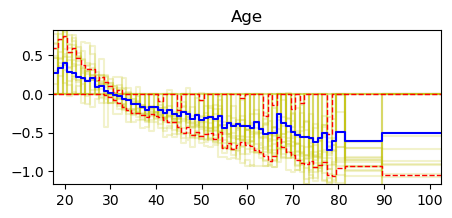

<Figure size 640x480 with 0 Axes>

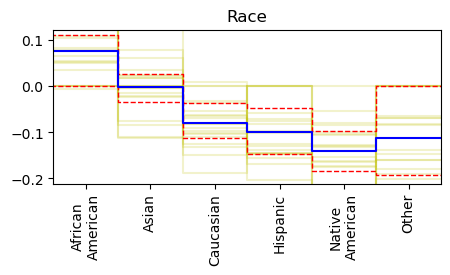

<Figure size 640x480 with 0 Axes>

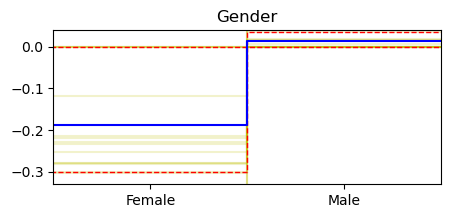

<Figure size 640x480 with 0 Axes>

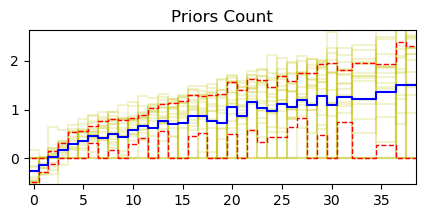

<Figure size 640x480 with 0 Axes>

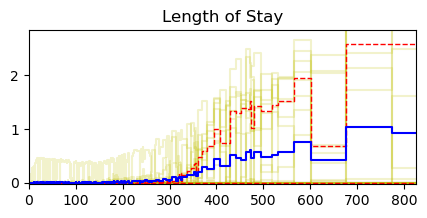

<Figure size 640x480 with 0 Axes>

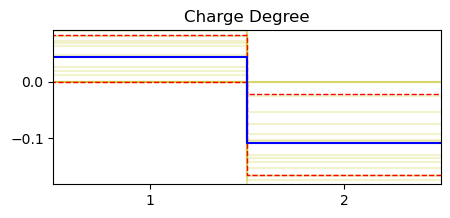

<Figure size 640x480 with 0 Axes>

In [17]:
with torch.no_grad():
    for i, colname in zip(range(len(columns)), columns):
        vX = np.sort(original_dfs['X'][colname].unique())
        X = np.zeros((len(vX), len(columns)))
        X[:, i] = np.sort(np.unique(data_x[:, i]))
        lines = []
        for m in model.models:
            out = m.forward(torch.tensor(X, dtype=torch.float32))[1][:,i]
            lines.append(out.cpu().numpy())
        plt.figure(figsize=(5,2))
        plt.tight_layout()
        plt.title(titles[colname])
        for l in lines:
            special_step(vX, l, color='y', alpha=0.2, where='mid')
        special_step(vX,  np.percentile(lines, 80, axis=0), color='r', linestyle='--', lw=1, where='mid')
        special_step(vX,  np.percentile(lines, 20, axis=0), color='r', linestyle='--', lw=1, where='mid')
        special_step(vX, np.mean(lines, axis=0), color='b', linestyle='-', where='mid')
        
        if colname in xticks:
            plt.xticks(vX, **xticks[colname])
        elif len(vX) < 10:
            plt.xticks(vX)
        plt.ylim(
            np.percentile(lines, 20, axis=0).min()-np.abs(np.percentile(lines, 20, axis=0).min()*0.1),
            np.percentile(lines, 80, axis=0).max()+np.abs(np.percentile(lines, 80, axis=0).max()*0.1),
        )
        plt.show()
        plt.savefig('out/recidivism_%d.png'%i)